In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [7]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [8]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount
0,2014,1,88
229447,2011,1,10
156483,2012,1,50
76159,2013,1,8
76160,2013,1,16


In [9]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()



400.963857957 std
442.363262216 mean
338.0 median
2500.0 max mult
0.00314465408805 min mult
1600.0 98%
559.0 q3
199.0 q1
48.0 02%
360.0 iqr
-341.0 min_q 1099.0 max_q


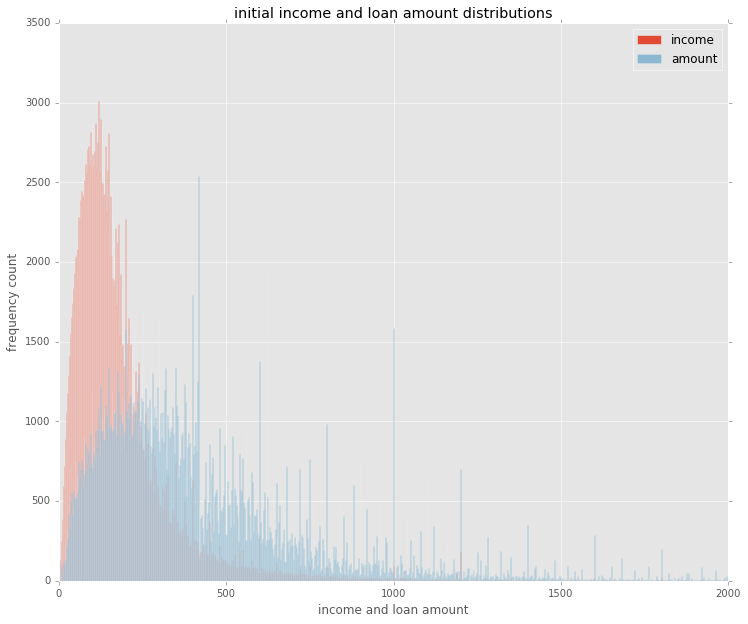

In [10]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5 * iqr #potential lower bound for quality
max_q = q3 + 1.5 * iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz



iteration 1
name 0 to 20
std 52.8055312177
mean 83.7295657727
median 70.0
max_mult 250.0
med_mult 4.916083916083917
min_mult 0.0526315789474
q98 228.0
q02 15.0
q75 110.0
q25 44.0
iqr 66.0
min_q -55.0
max_q 209.0
count of loans 3388
pct of total loans 1.15523761137


iteration 2
name 0 to 20
std 45.2523866219
mean 78.2004638834
median 68.0
max_mult 208.0
med_mult 4.766968325791855
min_mult 0.0526315789474
q98 190.0
q02 15.0
q75 104.0
q25 43.25
iqr 60.75
min_q -47.875
max_q 195.125
count of loans 3388
pct of total loans 1.15523761137


iteration 3
name 0 to 20
std 42.9161976808
mean 76.298115747
median 68.0
max_mult 187.0
med_mult 4.722222222222222
min_mult 0.0526315789474
q98 180.0
q02 15.0
q75 101.0
q25 43.0
iqr 58.0
min_q -44.0
max_q 188.0
count of loans 3388
pct of total loans 1.15523761137


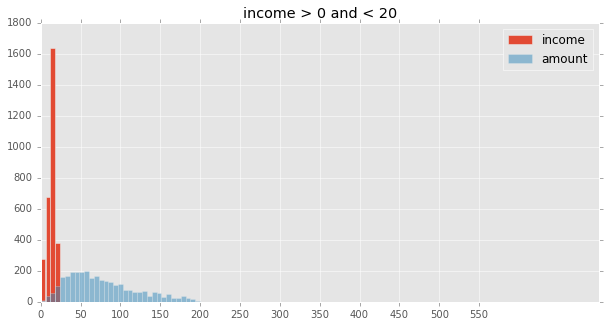



iteration 1
name 20 to 50
std 67.7235587987
mean 125.32070149
median 117.0
max_mult 16.1
med_mult 3.3488372093023258
min_mult 0.030303030303
q98 280.0
q02 23.0
q75 171.0
q25 71.0
iqr 100.0
min_q -79.0
max_q 321.0
count of loans 21784
pct of total loans 7.42789141858


iteration 2
name 20 to 50
std 67.1542036584
mean 124.88762192
median 116.0
max_mult 16.0
med_mult 3.34375
min_mult 0.030303030303
q98 278.0
q02 23.0
q75 170.0
q25 71.0
iqr 99.0
min_q -77.5
max_q 318.5
count of loans 21784
pct of total loans 7.42789141858


iteration 3
name 20 to 50
std 66.7519983142
mean 124.574779367
median 116.0
max_mult 15.3
med_mult 3.340909090909091
min_mult 0.030303030303
q98 276.0
q02 23.0
q75 170.0
q25 71.0
iqr 99.0
min_q -77.5
max_q 318.5
count of loans 21784
pct of total loans 7.42789141858


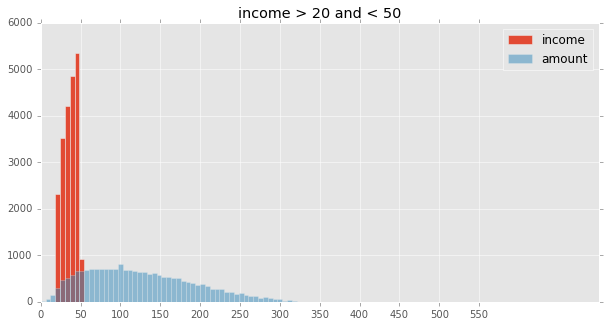



iteration 1
name 50 to 80
std 97.8303890875
mean 196.536610418
median 190.0
max_mult 9.6
med_mult 2.945945945945946
min_mult 0.0645161290323
q98 404.0
q02 36.0
q75 267.0
q25 118.0
iqr 149.0
min_q -105.5
max_q 490.5
count of loans 34379
pct of total loans 11.7225247466


iteration 2
name 50 to 80
std 97.6531341786
mean 196.405813271
median 190.0
max_mult 9.6
med_mult 2.9453300124533
min_mult 0.0645161290323
q98 402.0
q02 36.0
q75 266.0
q25 118.0
iqr 148.0
min_q -104.0
max_q 488.0
count of loans 34379
pct of total loans 11.7225247466


iteration 3
name 50 to 80
std 97.5270749494
mean 196.311257306
median 190.0
max_mult 9.6
med_mult 2.9444444444444446
min_mult 0.0645161290323
q98 401.0
q02 36.0
q75 266.0
q25 118.0
iqr 148.0
min_q -104.0
max_q 488.0
count of loans 34379
pct of total loans 11.7225247466


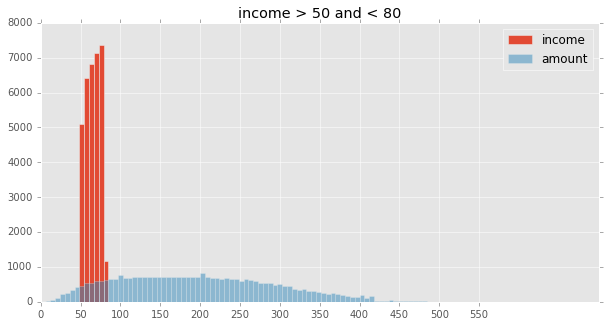



iteration 1
name 80 to 110
std 123.891553091
mean 259.183488782
median 249.0
max_mult 7.56097560976
med_mult 2.6448598130841123
min_mult 0.0747663551402
q98 534.0
q02 52.0
q75 345.0
q25 162.0
iqr 183.0
min_q -112.5
max_q 619.5
count of loans 39925
pct of total loans 13.6135955236


iteration 2
name 80 to 110
std 122.947646742
mean 258.464083653
median 249.0
max_mult 7.54320987654
med_mult 2.641304347826087
min_mult 0.0747663551402
q98 531.0
q02 52.0
q75 345.0
q25 161.0
iqr 184.0
min_q -115.0
max_q 621.0
count of loans 39925
pct of total loans 13.6135955236


iteration 3
name 80 to 110
std 122.947646742
mean 258.464083653
median 249.0
max_mult 7.54320987654
med_mult 2.641304347826087
min_mult 0.0747663551402
q98 531.0
q02 52.0
q75 345.0
q25 161.0
iqr 184.0
min_q -115.0
max_q 621.0
count of loans 39925
pct of total loans 13.6135955236


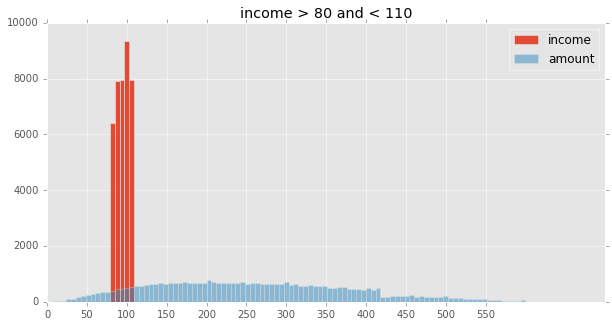



iteration 1
name 110 to 140
std 146.390789408
mean 318.468100304
median 304.0
max_mult 6.46428571429
med_mult 2.4473684210526314
min_mult 0.0545454545455
q98 634.0
q02 75.0
q75 411.0
q25 206.0
iqr 205.0
min_q -101.5
max_q 718.5
count of loans 39616
pct of total loans 13.5082329434


iteration 2
name 110 to 140
std 145.948495511
mean 318.098199923
median 304.0
max_mult 6.4
med_mult 2.446043165467626
min_mult 0.0545454545455
q98 631.0
q02 75.0
q75 410.0
q25 206.0
iqr 204.0
min_q -100.0
max_q 716.0
count of loans 39616
pct of total loans 13.5082329434


iteration 3
name 110 to 140
std 145.816088054
mean 317.986259386
median 304.0
max_mult 6.4
med_mult 2.4454545454545453
min_mult 0.0545454545455
q98 630.0
q02 75.0
q75 410.0
q25 206.0
iqr 204.0
min_q -100.0
max_q 716.0
count of loans 39616
pct of total loans 13.5082329434


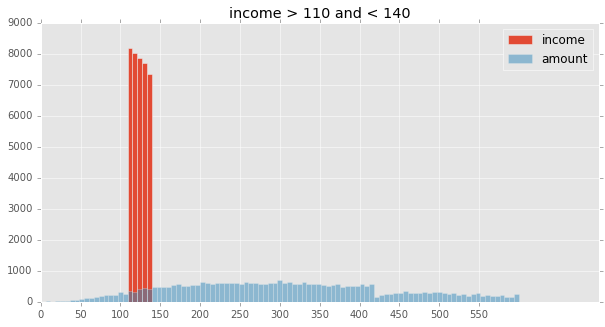



iteration 1
name 140 to 170
std 169.09658431
mean 375.293609828
median 353.0
max_mult 6.18439716312
med_mult 2.2980132450331126
min_mult 0.0533333333333
q98 756.88
q02 94.0
q75 493.0
q25 249.0
iqr 244.0
min_q -117.0
max_q 859.0
count of loans 33519
pct of total loans 11.4292826138


iteration 2
name 140 to 170
std 168.073475321
mean 374.494663643
median 353.0
max_mult 6.12142857143
med_mult 2.2962962962962963
min_mult 0.0533333333333
q98 750.0
q02 94.0
q75 492.0
q25 249.0
iqr 243.0
min_q -115.5
max_q 856.5
count of loans 33519
pct of total loans 11.4292826138


iteration 3
name 140 to 170
std 168.0180826
mean 374.450834543
median 352.5
max_mult 6.07142857143
med_mult 2.2962962962962963
min_mult 0.0533333333333
q98 750.0
q02 94.0
q75 492.0
q25 249.0
iqr 243.0
min_q -115.5
max_q 856.5
count of loans 33519
pct of total loans 11.4292826138


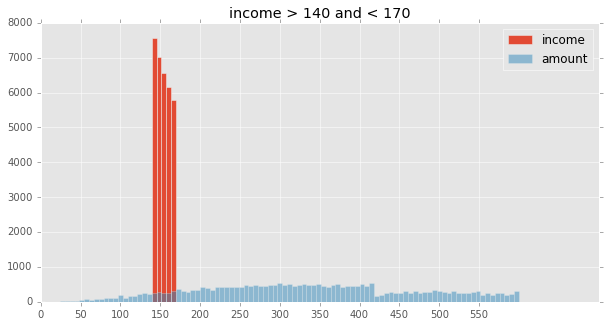



iteration 1
name 170 to 200
std 191.439707286
mean 430.468101185
median 400.0
max_mult 5.76470588235
med_mult 2.183503401360544
min_mult 0.0454545454545
q98 888.0
q02 115.0
q75 558.0
q25 288.0
iqr 270.0
min_q -117.0
max_q 963.0
count of loans 25558
pct of total loans 8.71474701046


iteration 2
name 170 to 200
std 189.297282956
mean 428.75765072
median 400.0
max_mult 5.64705882353
med_mult 2.1797752808988764
min_mult 0.0454545454545
q98 878.76
q02 115.0
q75 556.0
q25 288.0
iqr 268.0
min_q -114.0
max_q 958.0
count of loans 25558
pct of total loans 8.71474701046


iteration 3
name 170 to 200
std 188.120816232
mean 427.802182429
median 399.0
max_mult 5.59411764706
med_mult 2.177113095238095
min_mult 0.0454545454545
q98 871.0
q02 115.0
q75 555.0
q25 287.0
iqr 268.0
min_q -115.0
max_q 957.0
count of loans 25558
pct of total loans 8.71474701046


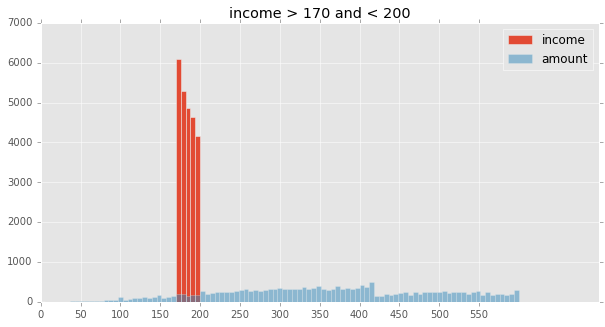



iteration 1
name 200 to 230
std 217.991759144
mean 492.518574601
median 470.0
max_mult 5.48
med_mult 2.201856398328811
min_mult 0.0384615384615
q98 1000.0
q02 128.0
q75 626.0
q25 329.0
iqr 297.0
min_q -116.5
max_q 1071.5
count of loans 20192
pct of total loans 6.88505249375


iteration 2
name 200 to 230
std 213.302979339
mean 488.638234099
median 468.0
max_mult 5.31
med_mult 2.1933164706954695
min_mult 0.0384615384615
q98 984.0
q02 128.0
q75 626.0
q25 328.0
iqr 298.0
min_q -119.0
max_q 1073.0
count of loans 20192
pct of total loans 6.88505249375


iteration 3
name 200 to 230
std 213.302979339
mean 488.638234099
median 468.0
max_mult 5.31
med_mult 2.1933164706954695
min_mult 0.0384615384615
q98 984.0
q02 128.0
q75 626.0
q25 328.0
iqr 298.0
min_q -119.0
max_q 1073.0
count of loans 20192
pct of total loans 6.88505249375


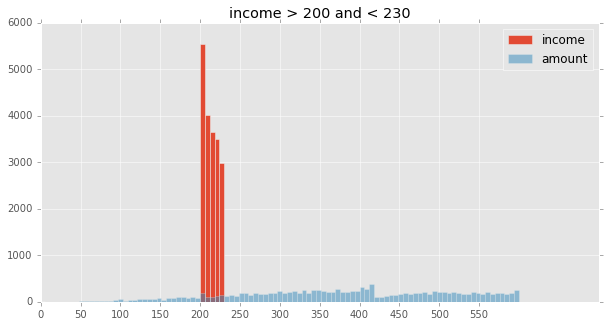



iteration 1
name 230 to 260
std 244.489296811
mean 554.539511542
median 536.0
max_mult 5.37391304348
med_mult 2.195744680851064
min_mult 0.0965250965251
q98 1120.0
q02 143.0
q75 706.0
q25 370.0
iqr 336.0
min_q -134.0
max_q 1210.0
count of loans 15255
pct of total loans 5.20163806419


iteration 2
name 230 to 260
std 241.582156795
mean 552.138597905
median 535.0
max_mult 5.22510822511
med_mult 2.1912697037935214
min_mult 0.0965250965251
q98 1103.0
q02 142.82
q75 704.0
q25 369.0
iqr 335.0
min_q -133.5
max_q 1206.5
count of loans 15255
pct of total loans 5.20163806419


iteration 3
name 230 to 260
std 241.167920877
mean 551.786079011
median 535.0
max_mult 5.21739130435
med_mult 2.190766423946914
min_mult 0.0965250965251
q98 1100.0
q02 142.66
q75 703.0
q25 369.0
iqr 334.0
min_q -132.0
max_q 1204.0
count of loans 15255
pct of total loans 5.20163806419


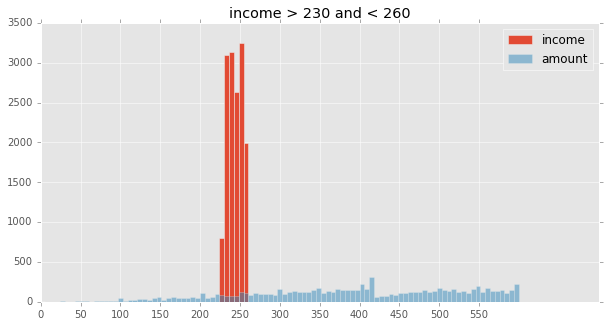



iteration 1
name 260 to 290
std 279.054841765
mean 620.005514706
median 591.0
max_mult 5.33969465649
med_mult 2.1636363636363636
min_mult 0.0280701754386
q98 1270.84
q02 157.0
q75 796.0
q25 406.0
iqr 390.0
min_q -179.0
max_q 1381.0
count of loans 11089
pct of total loans 3.78111861644


iteration 2
name 260 to 290
std 275.999783683
mean 617.502996773
median 590.0
max_mult 5.26717557252
med_mult 2.158490566037736
min_mult 0.0280701754386
q98 1250.0
q02 156.88
q75 792.0
q25 405.0
iqr 387.0
min_q -175.5
max_q 1372.5
count of loans 11089
pct of total loans 3.78111861644


iteration 3
name 260 to 290
std 274.565271542
mean 616.309106021
median 589.5
max_mult 5.24615384615
med_mult 2.157303370786517
min_mult 0.0280701754386
q98 1240.0
q02 156.54
q75 790.0
q25 405.0
iqr 385.0
min_q -172.5
max_q 1367.5
count of loans 11089
pct of total loans 3.78111861644


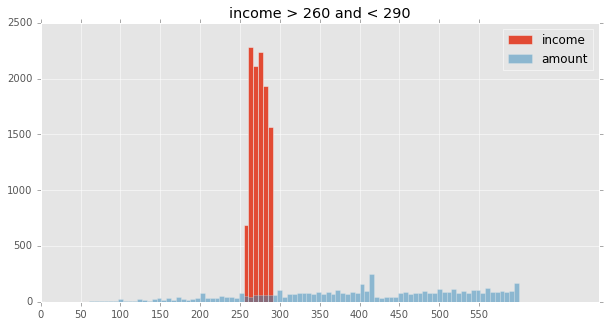



iteration 1
name 290 to 320
std 319.806169848
mean 689.395265173
median 645.0
max_mult 5.55172413793
med_mult 2.135593220338983
min_mult 0.0253968253968
q98 1440.0
q02 164.0
q75 900.0
q25 439.0
iqr 461.0
min_q -252.5
max_q 1591.5
count of loans 8707
pct of total loans 2.96890610455


iteration 2
name 290 to 320
std 316.465098667
mean 686.743831471
median 643.0
max_mult 5.46206896552
med_mult 2.131620194687345
min_mult 0.0253968253968
q98 1416.36
q02 163.64
q75 900.0
q25 436.75
iqr 463.25
min_q -258.125
max_q 1594.875
count of loans 8707
pct of total loans 2.96890610455


iteration 3
name 290 to 320
std 316.465098667
mean 686.743831471
median 643.0
max_mult 5.46206896552
med_mult 2.131620194687345
min_mult 0.0253968253968
q98 1416.36
q02 163.64
q75 900.0
q25 436.75
iqr 463.25
min_q -258.125
max_q 1594.875
count of loans 8707
pct of total loans 2.96890610455


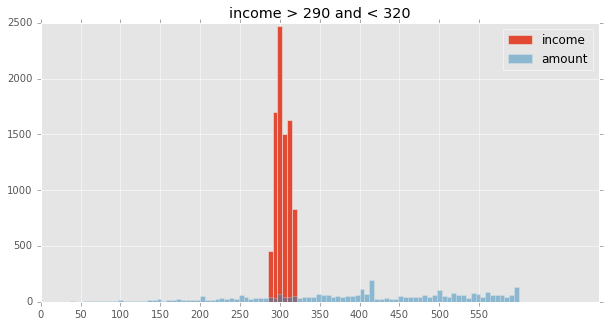



iteration 1
name 320 to 350
std 339.018747511
mean 740.923160848
median 696.0
max_mult 5.38125
med_mult 2.0775056605517306
min_mult 0.14450867052
q98 1515.7
q02 183.3
q75 972.25
q25 488.0
iqr 484.25
min_q -238.375
max_q 1698.625
count of loans 6516
pct of total loans 2.22182062447


iteration 2
name 320 to 350
std 334.766479671
mean 737.579918674
median 694.0
max_mult 5.25
med_mult 2.07492795389049
min_mult 0.14450867052
q98 1500.0
q02 182.86
q75 967.5
q25 487.25
iqr 480.25
min_q -233.125
max_q 1687.875
count of loans 6516
pct of total loans 2.22182062447


iteration 3
name 320 to 350
std 334.581513879
mean 737.431252933
median 694.0
max_mult 5.25
med_mult 2.07492795389049
min_mult 0.14450867052
q98 1500.0
q02 182.84
q75 966.0
q25 487.0
iqr 479.0
min_q -231.5
max_q 1684.5
count of loans 6516
pct of total loans 2.22182062447


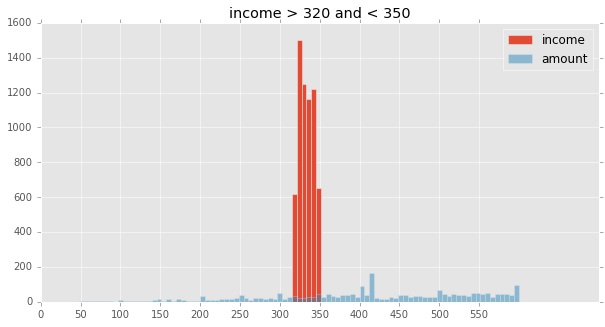



iteration 1
name 350 to 380
std 370.132682193
mean 779.333827069
median 722.0
max_mult 5.23428571429
med_mult 1.9887640449438202
min_mult 0.139275766017
q98 1641.0
q02 173.0
q75 1017.0
q25 504.0
iqr 513.0
min_q -265.5
max_q 1786.5
count of loans 5484
pct of total loans 1.86993006516


iteration 2
name 350 to 380
std 364.156037917
mean 774.511904762
median 720.0
max_mult 5.02571428571
med_mult 1.9829299878591664
min_mult 0.139275766017
q98 1600.0
q02 172.5
q75 1009.5
q25 501.0
iqr 508.5
min_q -261.75
max_q 1772.25
count of loans 5484
pct of total loans 1.86993006516


iteration 3
name 350 to 380
std 363.021326499
mean 773.572705269
median 720.0
max_mult 5.02571428571
med_mult 1.9813829787234043
min_mult 0.139275766017
q98 1600.0
q02 172.4
q75 1008.0
q25 501.0
iqr 507.0
min_q -259.5
max_q 1768.5
count of loans 5484
pct of total loans 1.86993006516


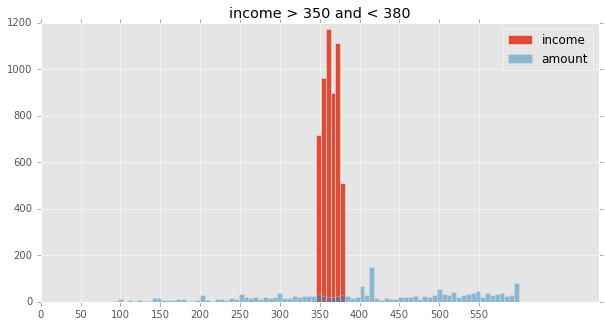



iteration 1
name 380 to 410
std 398.494884828
mean 829.549987778
median 765.0
max_mult 5.15789473684
med_mult 1.9575
min_mult 0.05
q98 1751.2
q02 197.8
q75 1100.0
q25 528.0
iqr 572.0
min_q -330.0
max_q 1958.0
count of loans 4159
pct of total loans 1.41813259318


iteration 2
name 380 to 410
std 396.756035608
mean 828.161771904
median 764.0
max_mult 5.02894736842
med_mult 1.9550561097256858
min_mult 0.05
q98 1750.0
q02 197.7
q75 1100.0
q25 528.0
iqr 572.0
min_q -330.0
max_q 1958.0
count of loans 4159
pct of total loans 1.41813259318


iteration 3
name 380 to 410
std 396.756035608
mean 828.161771904
median 764.0
max_mult 5.02894736842
med_mult 1.9550561097256858
min_mult 0.05
q98 1750.0
q02 197.7
q75 1100.0
q25 528.0
iqr 572.0
min_q -330.0
max_q 1958.0
count of loans 4159
pct of total loans 1.41813259318


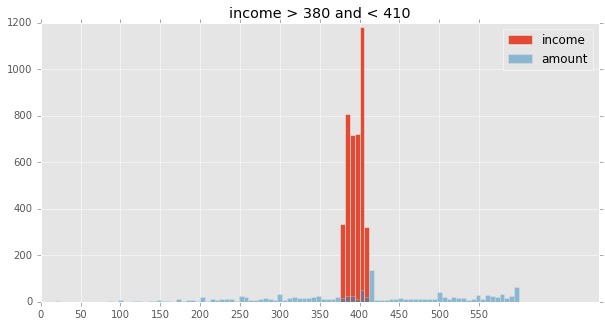



iteration 1
name 410 to 440
std 435.95686034
mean 893.662179487
median 840.0
max_mult 4.94202898551
med_mult 1.9894467100187367
min_mult 0.0571428571429
q98 1960.0
q02 200.0
q75 1192.25
q25 560.0
iqr 632.25
min_q -388.375
max_q 2140.625
count of loans 3137
pct of total loans 1.06965182611


iteration 2
name 410 to 440
std 435.95686034
mean 893.662179487
median 840.0
max_mult 4.94202898551
med_mult 1.9894467100187367
min_mult 0.0571428571429
q98 1960.0
q02 200.0
q75 1192.25
q25 560.0
iqr 632.25
min_q -388.375
max_q 2140.625
count of loans 3137
pct of total loans 1.06965182611


iteration 3
name 410 to 440
std 435.95686034
mean 893.662179487
median 840.0
max_mult 4.94202898551
med_mult 1.9894467100187367
min_mult 0.0571428571429
q98 1960.0
q02 200.0
q75 1192.25
q25 560.0
iqr 632.25
min_q -388.375
max_q 2140.625
count of loans 3137
pct of total loans 1.06965182611


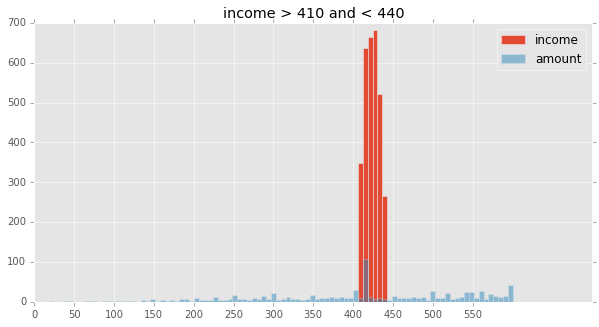



iteration 1
name 440 to 470
std 459.790523695
mean 911.181853735
median 850.0
max_mult 4.85651214128
med_mult 1.8781038374717833
min_mult 0.0789473684211
q98 1995.88
q02 200.0
q75 1206.0
q25 560.0
iqr 646.0
min_q -409.0
max_q 2175.0
count of loans 2573
pct of total loans 0.877339543702


iteration 2
name 440 to 470
std 459.172838526
mean 910.677621283
median 850.0
max_mult 4.75892857143
med_mult 1.877377909925319
min_mult 0.0789473684211
q98 1995.0
q02 200.0
q75 1201.5
q25 559.75
iqr 641.75
min_q -402.875
max_q 2164.125
count of loans 2573
pct of total loans 0.877339543702


iteration 3
name 440 to 470
std 458.585935908
mean 910.184735812
median 850.0
max_mult 4.75892857143
med_mult 1.8766519823788546
min_mult 0.0789473684211
q98 1994.44
q02 200.0
q75 1200.0
q25 559.5
iqr 640.5
min_q -401.25
max_q 2160.75
count of loans 2573
pct of total loans 0.877339543702


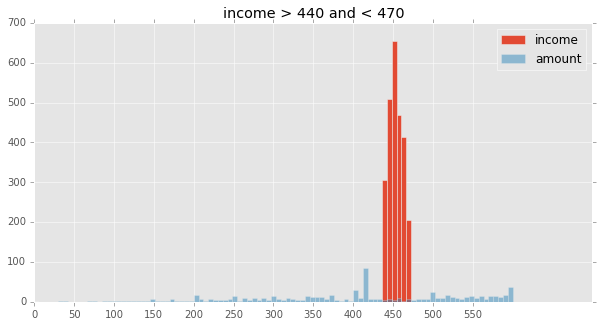



iteration 1
name 470 to 500
std 487.178472014
mean 951.527238276
median 884.0
max_mult 5.05307855626
med_mult 1.8200836820083681
min_mult 0.0801603206413
q98 2000.0
q02 200.0
q75 1296.5
q25 568.0
iqr 728.5
min_q -524.75
max_q 2389.25
count of loans 2128
pct of total loans 0.725603788961


iteration 2
name 470 to 500
std 486.271643413
mean 950.840758294
median 884.0
max_mult 5.05307855626
med_mult 1.8191327500950931
min_mult 0.0801603206413
q98 2000.0
q02 200.0
q75 1295.0
q25 568.0
iqr 727.0
min_q -522.5
max_q 2385.5
count of loans 2128
pct of total loans 0.725603788961


iteration 3
name 470 to 500
std 485.37681316
mean 950.158843054
median 884.0
max_mult 5.05307855626
med_mult 1.8181818181818181
min_mult 0.0801603206413
q98 2000.0
q02 200.0
q75 1295.0
q25 568.0
iqr 727.0
min_q -522.5
max_q 2385.5
count of loans 2128
pct of total loans 0.725603788961


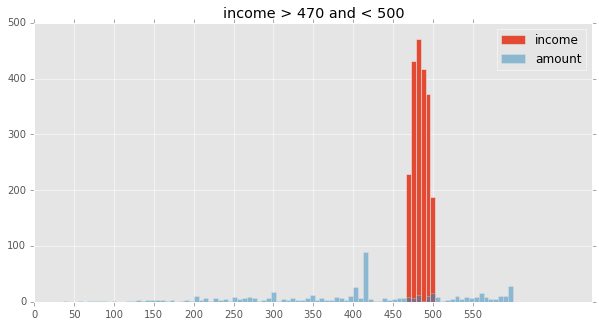



iteration 1
name 500 to 530
std 491.281918475
mean 983.078634247
median 930.0
max_mult 4.72440944882
med_mult 1.812375249500998
min_mult 0.05
q98 2000.0
q02 195.64
q75 1320.0
q25 604.0
iqr 716.0
min_q -470.0
max_q 2394.0
count of loans 1954
pct of total loans 0.666273403961


iteration 2
name 500 to 530
std 488.436871117
mean 980.86373057
median 928.0
max_mult 4.72222222222
med_mult 1.8083152625950571
min_mult 0.05
q98 2000.0
q02 195.58
q75 1320.0
q25 604.0
iqr 716.0
min_q -470.0
max_q 2394.0
count of loans 1954
pct of total loans 0.666273403961


iteration 3
name 500 to 530
std 488.436871117
mean 980.86373057
median 928.0
max_mult 4.72222222222
med_mult 1.8083152625950571
min_mult 0.05
q98 2000.0
q02 195.58
q75 1320.0
q25 604.0
iqr 716.0
min_q -470.0
max_q 2394.0
count of loans 1954
pct of total loans 0.666273403961


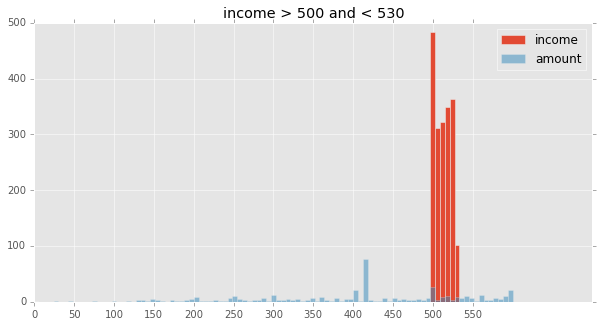



iteration 1
name 530 to 560
std 517.489385305
mean 987.355726168
median 938.0
max_mult 4.63568773234
med_mult 1.7216117216117217
min_mult 0.103825136612
q98 2000.0
q02 194.24
q75 1340.0
q25 588.5
iqr 751.5
min_q -538.75
max_q 2467.25
count of loans 1581
pct of total loans 0.539088153359


iteration 2
name 530 to 560
std 513.722453849
mean 984.450641026
median 937.0
max_mult 4.61393596987
med_mult 1.7209909332356443
min_mult 0.103825136612
q98 2000.0
q02 194.18
q75 1336.75
q25 588.0
iqr 748.75
min_q -535.125
max_q 2459.875
count of loans 1581
pct of total loans 0.539088153359


iteration 3
name 530 to 560
std 513.722453849
mean 984.450641026
median 937.0
max_mult 4.61393596987
med_mult 1.7209909332356443
min_mult 0.103825136612
q98 2000.0
q02 194.18
q75 1336.75
q25 588.0
iqr 748.75
min_q -535.125
max_q 2459.875
count of loans 1581
pct of total loans 0.539088153359


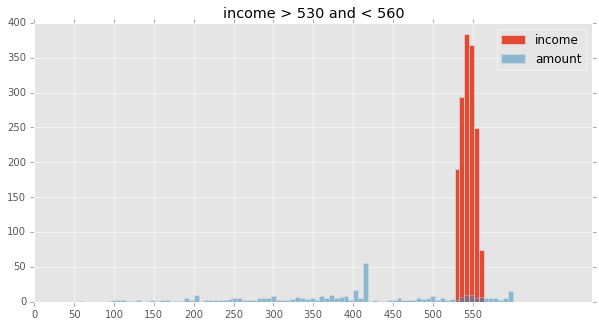



iteration 1
name 560 to 590
std 507.341056209
mean 1029.07033145
median 974.0
max_mult 4.46428571429
med_mult 1.6955017301038062
min_mult 0.0557491289199
q98 2014.0
q02 237.88
q75 1364.0
q25 626.0
iqr 738.0
min_q -481.0
max_q 2471.0
count of loans 1252
pct of total loans 0.426905988618


iteration 2
name 560 to 590
std 499.577736017
mean 1023.08766234
median 970.0
max_mult 4.32098765432
med_mult 1.6917149914089347
min_mult 0.0557491289199
q98 2000.0
q02 237.48
q75 1360.0
q25 626.0
iqr 734.0
min_q -475.0
max_q 2461.0
count of loans 1252
pct of total loans 0.426905988618


iteration 3
name 560 to 590
std 499.577736017
mean 1023.08766234
median 970.0
max_mult 4.32098765432
med_mult 1.6917149914089347
min_mult 0.0557491289199
q98 2000.0
q02 237.48
q75 1360.0
q25 626.0
iqr 734.0
min_q -475.0
max_q 2461.0
count of loans 1252
pct of total loans 0.426905988618


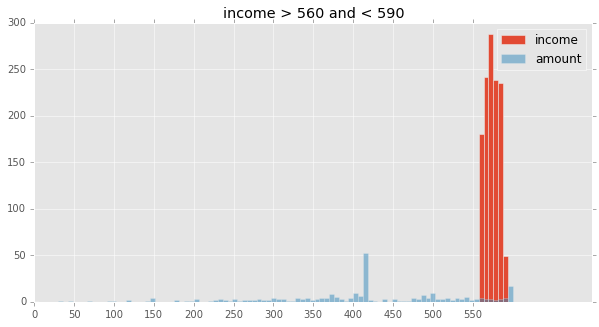



iteration 1
name 590 to 620
std 564.939065964
mean 1077.37307033
median 1000.0
max_mult 4.51559934319
med_mult 1.6775882780907907
min_mult 0.0780487804878
q98 2314.0
q02 170.9
q75 1470.0
q25 626.0
iqr 844.0
min_q -640.0
max_q 2736.0
count of loans 1177
pct of total loans 0.401332546808


iteration 2
name 590 to 620
std 563.049525714
mean 1075.93733906
median 1000.0
max_mult 4.5
med_mult 1.6750418760469012
min_mult 0.0780487804878
q98 2294.12
q02 170.64
q75 1470.0
q25 626.0
iqr 844.0
min_q -640.0
max_q 2736.0
count of loans 1177
pct of total loans 0.401332546808


iteration 3
name 590 to 620
std 563.049525714
mean 1075.93733906
median 1000.0
max_mult 4.5
med_mult 1.6750418760469012
min_mult 0.0780487804878
q98 2294.12
q02 170.64
q75 1470.0
q25 626.0
iqr 844.0
min_q -640.0
max_q 2736.0
count of loans 1177
pct of total loans 0.401332546808


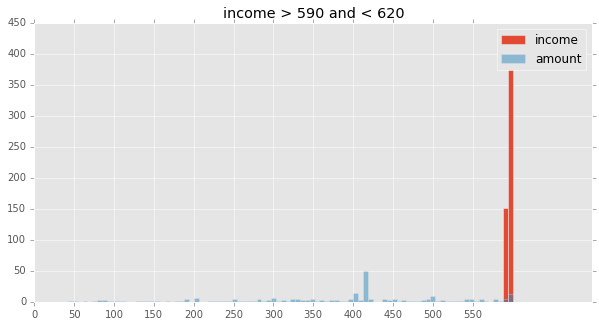



iteration 1
name 620 to 650
std 562.210198147
mean 1103.63802978
median 1041.0
max_mult 4.44711538462
med_mult 1.6474358974358974
min_mult 0.0283018867925
q98 2271.2
q02 184.32
q75 1500.0
q25 643.0
iqr 857.0
min_q -642.5
max_q 2785.5
count of loans 880
pct of total loans 0.30006171724


iteration 2
name 620 to 650
std 562.210198147
mean 1103.63802978
median 1041.0
max_mult 4.44711538462
med_mult 1.6474358974358974
min_mult 0.0283018867925
q98 2271.2
q02 184.32
q75 1500.0
q25 643.0
iqr 857.0
min_q -642.5
max_q 2785.5
count of loans 880
pct of total loans 0.30006171724


iteration 3
name 620 to 650
std 562.210198147
mean 1103.63802978
median 1041.0
max_mult 4.44711538462
med_mult 1.6474358974358974
min_mult 0.0283018867925
q98 2271.2
q02 184.32
q75 1500.0
q25 643.0
iqr 857.0
min_q -642.5
max_q 2785.5
count of loans 880
pct of total loans 0.30006171724


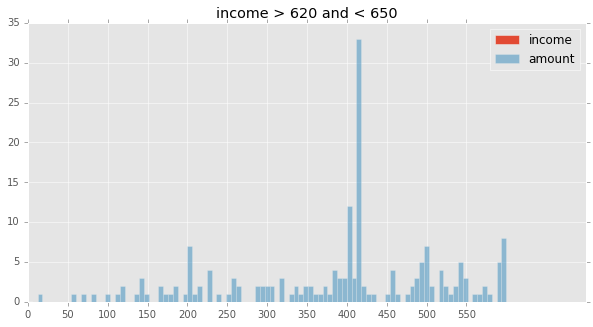



iteration 1
name 650 to 680
std 573.251967691
mean 1105.960193
median 1000.0
max_mult 4.18569254186
med_mult 1.5337423312883436
min_mult 0.113636363636
q98 2270.32
q02 200.0
q75 1500.0
q25 650.0
iqr 850.0
min_q -625.0
max_q 2775.0
count of loans 844
pct of total loans 0.287786465171


iteration 2
name 650 to 680
std 573.251967691
mean 1105.960193
median 1000.0
max_mult 4.18569254186
med_mult 1.5337423312883436
min_mult 0.113636363636
q98 2270.32
q02 200.0
q75 1500.0
q25 650.0
iqr 850.0
min_q -625.0
max_q 2775.0
count of loans 844
pct of total loans 0.287786465171


iteration 3
name 650 to 680
std 573.251967691
mean 1105.960193
median 1000.0
max_mult 4.18569254186
med_mult 1.5337423312883436
min_mult 0.113636363636
q98 2270.32
q02 200.0
q75 1500.0
q25 650.0
iqr 850.0
min_q -625.0
max_q 2775.0
count of loans 844
pct of total loans 0.287786465171


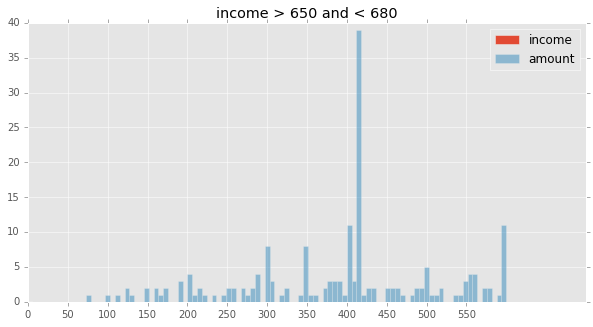



iteration 1
name 680 to 710
std 579.852417099
mean 1121.56706507
median 1071.0
max_mult 4.08759124088
med_mult 1.5365853658536586
min_mult 0.0845481049563
q98 2500.0
q02 200.0
q75 1500.0
q25 650.0
iqr 850.0
min_q -625.0
max_q 2775.0
count of loans 759
pct of total loans 0.258803231119


iteration 2
name 680 to 710
std 559.298387785
mean 1105.86058981
median 1060.0
max_mult 3.86402266289
med_mult 1.5277751059641294
min_mult 0.0845481049563
q98 2287.4
q02 198.1
q75 1500.0
q25 646.5
iqr 853.5
min_q -633.75
max_q 2780.25
count of loans 759
pct of total loans 0.258803231119


iteration 3
name 680 to 710
std 559.298387785
mean 1105.86058981
median 1060.0
max_mult 3.86402266289
med_mult 1.5277751059641294
min_mult 0.0845481049563
q98 2287.4
q02 198.1
q75 1500.0
q25 646.5
iqr 853.5
min_q -633.75
max_q 2780.25
count of loans 759
pct of total loans 0.258803231119


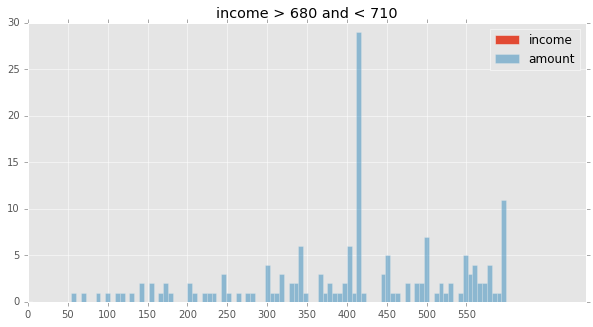



iteration 1
name 710 to 740
std 608.69516889
mean 1127.19032258
median 1037.5
max_mult 4.08333333333
med_mult 1.425837986738729
min_mult 0.0208333333333
q98 2487.48
q02 192.76
q75 1561.0
q25 655.5
iqr 905.5
min_q -702.75
max_q 2919.25
count of loans 626
pct of total loans 0.213452994309


iteration 2
name 710 to 740
std 600.852640085
mean 1121.3236246
median 1033.5
max_mult 4.0676056338
med_mult 1.4208785604740846
min_mult 0.0208333333333
q98 2462.64
q02 192.68
q75 1520.0
q25 654.5
iqr 865.5
min_q -643.75
max_q 2818.25
count of loans 626
pct of total loans 0.213452994309


iteration 3
name 710 to 740
std 585.808289126
mean 1109.89739414
median 1028.5
max_mult 3.73489010989
med_mult 1.4051160434702523
min_mult 0.0208333333333
q98 2300.0
q02 192.52
q75 1506.0
q25 651.0
iqr 855.0
min_q -631.5
max_q 2788.5
count of loans 626
pct of total loans 0.213452994309


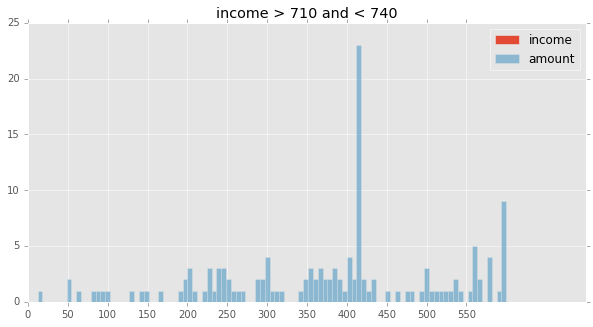

In [70]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 20
bin_step = 30
iqr_iter = 3
pct_of_loans = OrderedDict({})
first = True
while bin_max < 750:#bank_df.income.max():
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['med_mult'] = graph_bin.mult.median()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100
    
    #iterate over dataframe bin to remove outliers using IQR * 1.5
    count=1
    while count <= iqr_iter:
        #remove outliers
        graph_bin = graph_bin[(graph_bin.amount > bin_stats['min_q']) & (graph_bin.amount < bin_stats['max_q'])]
        print('\n\niteration {num}'.format(num=count))
        #reset bin stats to reflect IQR cutoffs
        bin_stats['std']= graph_bin.amount.std()
        bin_stats['mean'] = graph_bin.amount.mean()
        bin_stats['median'] = graph_bin.amount.median()
        bin_stats['max_mult'] = graph_bin.mult.max()
        bin_stats['med_mult'] = graph_bin.mult.median()
        bin_stats['min_mult'] = graph_bin.mult.min()
        bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
        bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
        bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
        bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
        bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
        bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
        bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']

        count+=1
        for key, value in bin_stats.items(): #print descriptive stats
            print(key,value)
        
    if first: 
        first=False
        bin_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate initial dataframe
    else:
        concat_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate subsequent dataframe 
        bin_df = pd.concat([bin_df, concat_df], axis=0) #concatenate dataframes each cycle
    

    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 600 #set maximum x axis value
    xsteps= 100 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
    
path = 'linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'{iqr_iter}IQR.csv'.format(iqr_iter=iqr_iter))

In [72]:

bin_df.reset_index(inplace=True, drop=True) #set an integer index instead of index passed at creation
bin_df.head(20)

,name,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0 to 20,42.916198,76.298116,68.0,187.000000,4.722222,0.052632,180.00,15.00,101.00,43.00,58.00,-44.000,188.000,3388,1.155238
1,20 to 50,66.751998,124.574779,116.0,15.300000,3.340909,0.030303,276.00,23.00,170.00,71.00,99.00,-77.500,318.500,21784,7.427891
2,50 to 80,97.527075,196.311257,190.0,9.600000,2.944444,0.064516,401.00,36.00,266.00,118.00,148.00,-104.000,488.000,34379,11.722525
3,80 to 110,122.947647,258.464084,249.0,7.543210,2.641304,0.074766,531.00,52.00,345.00,161.00,184.00,-115.000,621.000,39925,13.613596
4,110 to 140,145.816088,317.986259,304.0,6.400000,2.445455,0.054545,630.00,75.00,410.00,206.00,204.00,-100.000,716.000,39616,13.508233
5,140 to 170,168.018083,374.450835,352.5,6.071429,2.296296,0.053333,750.00,94.00,492.00,249.00,243.00,-115.500,856.500,33519,11.429283
6,170 to 200,188.120816,427.802182,399.0,5.594118,2.177113,0.045455,871.00,115.00,555.00,287.00,268.00,-115.000,957.000,25558,8.714747
7,200 to 230,213.302979,488.638234,468.0,5.310000,2.193316,0.038462,984.00,128.00,626.00,328.00,298.00,-119.000,1073.000,20192,6.885052
8,230 to 260,241.167921,551.786079,535.0,5.217391,2.190766,0.096525,1100.00,142.66,703.00,369.00,334.00,-132.000,1204.000,15255,5.201638
9,260 to 290,274.565272,616.309106,589.5,5.246154,2.157303,0.028070,1240.00,156.54,790.00,405.00,385.00,-172.500,1367.500,11089,3.781119


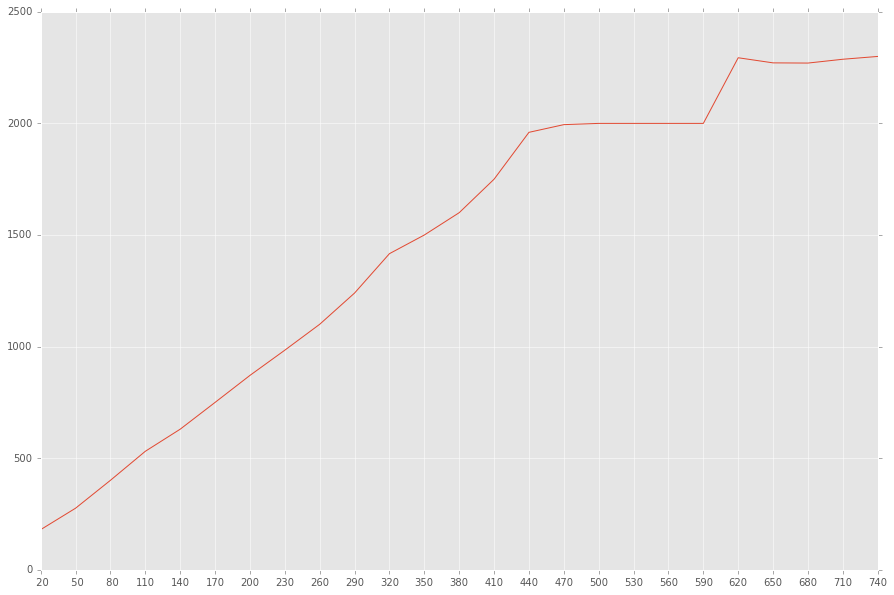

In [84]:
fig = plt.figure(figsize=(15,10))
xticks=[x[-3:] for x in bin_df.name] #get xtick names as list
ax = plt.subplot()
plt.xticks(x,xticks) #set xtick names
x = range(len(bin_df.name))
y = bin_df.q98
plt.plot(x,y)
plt.show(fig)

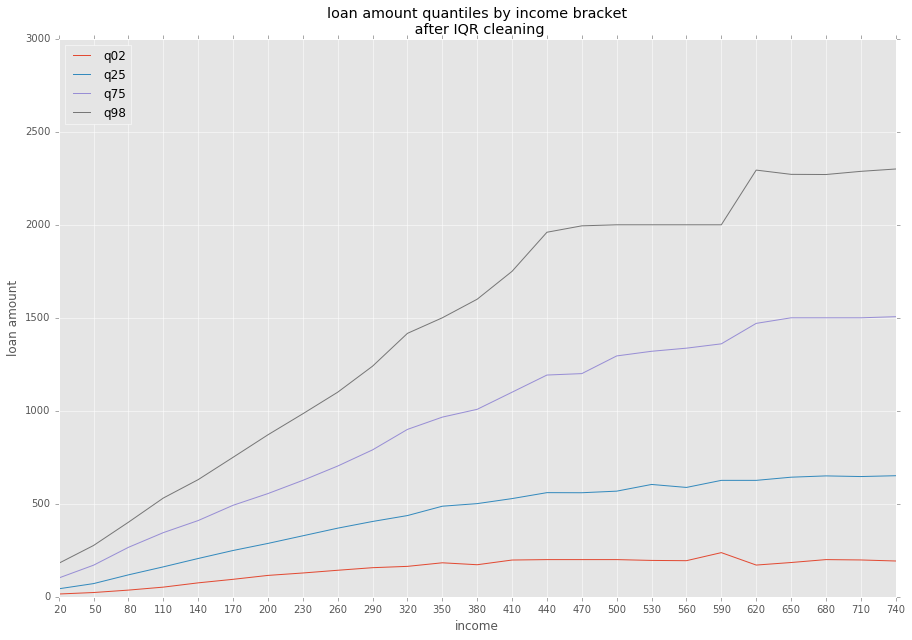

In [104]:
fig = plt.figure(figsize=(15,10))
xticks=[x[-3:] for x in bin_df.name] #get xtick names as list
ax = plt.subplot()
plt.xticks(x,xticks) #set xtick names
x = range(len(bin_df.name))

y = bin_df.q02
y1 = bin_df.q25
y2 = bin_df.q75
y3 = bin_df.q98
plt.plot(x,y, label='q02')
plt.plot(x,y1, label='q25')
plt.plot(x,y2, label='q75')
plt.plot(x,y3, label='q98')
ax=plt.subplot()
ax.set_ylim(0,3000)
plt.ylabel('loan amount')
plt.xlabel('income')
plt.legend(loc='upper left') #turn on legend and set location
plt.title('loan amount quantiles by income bracket\n after IQR cleaning')
plt.show(fig)